In [1]:
import rioxarray
import rasterio
import glob
import xarray as xr
import numpy as np

In [2]:
from geomod import predictor
from geomod import utils

### Preparing the Data

In [3]:
data_directory = '/home/jovyan/PlanetaryComputerExamples/adv-python-final/geomod/example-notebooks/data/'

In [4]:
driver_map_names = ['elevation01', 'geology01', 'protection01']
driver_map_paths = [data_directory+name+'.rst' for name in driver_map_names]
driver_map_xr_list = [rioxarray.open_rasterio(map, masked=True) for map in driver_map_paths]
all_driver_maps_xr = xr.concat(driver_map_xr_list, dim='band').assign_coords(band=driver_map_names)

In [5]:
all_driver_maps_xr = all_driver_maps_xr.round().astype('int')

/srv/conda/envs/notebook/lib/python3.11/site-packages/xarray/core/duck_array_ops.py:188: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [6]:
classification_map_xr = rioxarray.open_rasterio(data_directory+'1985anderson01.rst', masked=True)

In [7]:
def get_metadata(rdc_file):
# Open the text file for reading
    metadata_dict = {}
    with open(rdc_file, "r") as file:
    # Read each line in the file
        for line in file:
            # Split each line into key and value using ':'
            key, value = line.strip().split(':')[0:2]
            # Store the key-value pair in the dictionary
            metadata_dict[key.strip()] = value.strip()
    return metadata_dict

In [8]:
print(get_metadata(data_directory+'1985anderson01.RDC'))

{'file format': 'IDRISI Raster A.1', 'file title': '1985 Anderson Land Category', 'data type': 'byte', 'file type': 'binary', 'columns': '512', 'rows': '512', 'ref. system': 'spc83ma1', 'ref. units': 'm', 'unit dist.': '1.0000000', 'min. X': '242160.0000000', 'max. X': '257520.0000000', 'min. Y': '923060.0000000', 'max. Y': '938420.0000000', "pos'n error": 'unknown', 'resolution': '30', 'min. value': '0', 'max. value': '7', 'display min': '0', 'display max': '7', 'value units': 'categories', 'value error': 'unknown', 'flag value': '0', "flag def'n": 'background', 'legend cats': '7', 'code      1': 'Built', 'code      2': 'Agriculture', 'code      3': 'Range', 'code      4': 'Forest', 'code      5': 'Water', 'code      6': 'Wetland', 'code      7': 'Barren', 'lineage': '3*C'}


In [9]:
input_classification_map_xr = rioxarray.open_rasterio(data_directory+'1985anderson01.rst', masked=True)
land_cover_map = utils.reclassify_landcover_map(input_classification_map_xr, 1)

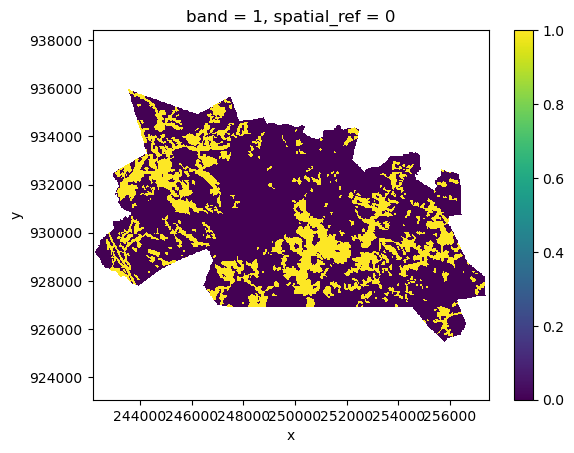

In [10]:
land_cover_map.plot()

In [11]:
validation_class_map_xr = rioxarray.open_rasterio(data_directory+'1999anderson01.rst', masked=True)
validation_map = utils.reclassify_landcover_map(validation_class_map_xr, 1)

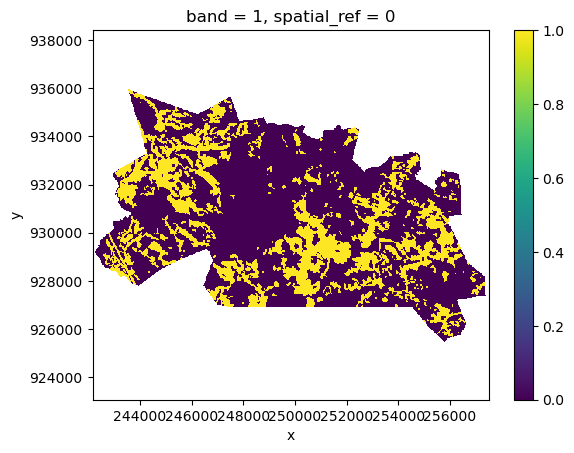

In [12]:
validation_map.plot()

In [13]:
weights = {'elevation01':.80, 'protection01':.10, 'geology01':.10}

In [14]:
suitability_map = utils.create_suitability_map_xarray(all_driver_maps_xr, land_cover_map, weights=weights)
suitability_map_unweighted = utils.create_suitability_map_xarray(all_driver_maps_xr, land_cover_map, weights=None)

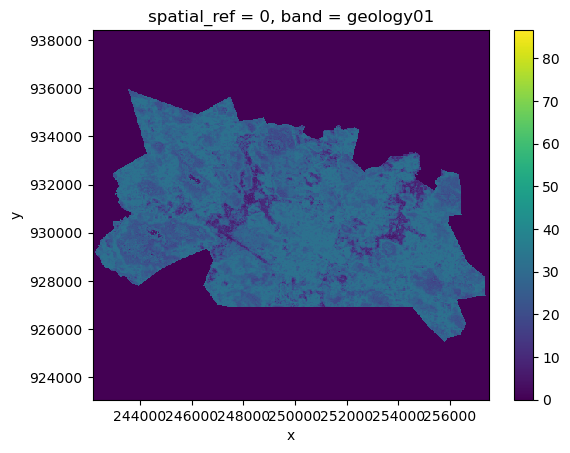

In [15]:
suitability_map.plot()

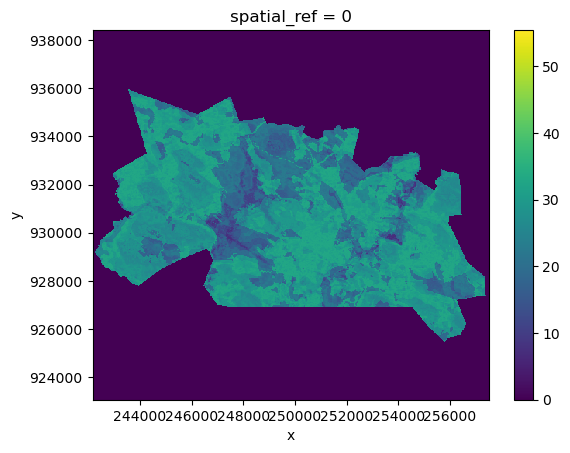

In [16]:
suitability_map_unweighted.plot()

In [20]:
# Get areas with 0 that border a 1 - this will be done iteratively during the main loop
land_change_borders = utils.get_edges(land_cover_map, (3,3))

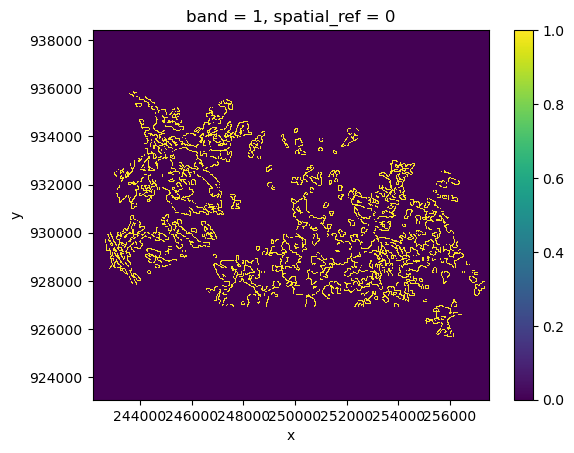

In [27]:
land_change_borders.plot()

In [25]:
# add to get a new land cover map. This can then be used to search along the new border.
updated_land_cover = xr.where(land_change_borders==1, 1, land_cover_map)

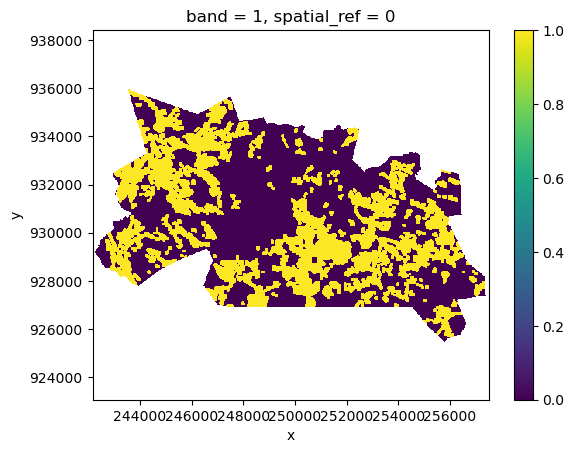

In [26]:
updated_land_cover.plot()

In [108]:
change_pixel_quantity = validation_map.sum().item() - land_cover_map.sum().item()
print('how many pixels change between steps 1 and 2:', change_pixel_quantity)

how many pixels change between steps 1 and 2: 3159.0


In [109]:
# get a map of suitability only on pixels that are not developed
suitability_change_xr = xr.where(land_cover_map==0, suitability_map_unweighted, np.nan)

In [110]:
# get number of pixels that can be changed
changeable_pixels = xr.where(land_cover_map==0, 1, 0).sum().item()
print('the number of pixels that can be changed:', changeable_pixels)

the number of pixels that can be changed: 75717


In [128]:
suitability_threshold = suitability_change_xr.quantile(q = 1 - (change_pixel_quantity/changeable_pixels), skipna=True).values

In [129]:
print(suitability_threshold)

32.793459900027706


In [136]:
change_pixels = xr.where(suitability_change_xr > suitability_threshold, 1, 0)

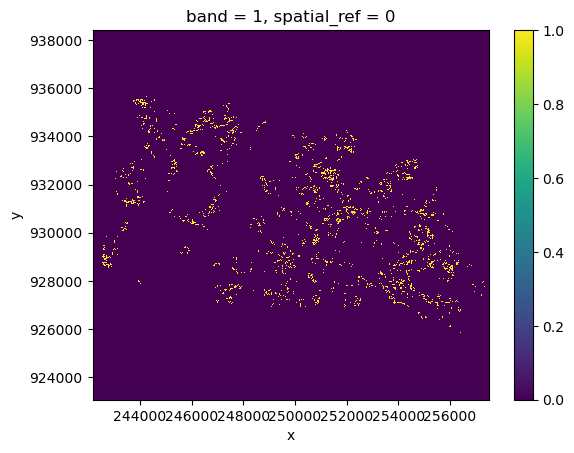

In [134]:
change_pixels.plot()

In [135]:
change_pixels.sum().item()

4070